**Note:** In a moving average process, the present value is linearly dependent on the mean, the current error term, and past error terms. The
order q can be inferred using the ACF plot, where autocorrelation coefficients will be significant up until lag q only. In the case where the ACF plot shows a slowly decaying pattern or a sinusoidal pattern, it is possible that you are in the presence of an autoregressive process instead of a moving average process.

In the autoregressive process, the present value is linearly dependent on its own past value. In other words, it is a regression of the  variable against itself. You saw that we can infer the order p using the PACF plot, where the partial autocorrelation coefficients will be significant up until lag p only

In [1]:
import numpy as np
import pandas as pd
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Forecasting bandwidth usage for data centers

### Simulate ARMA(1,1) process

In [2]:
np.random.seed(42)
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])
ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

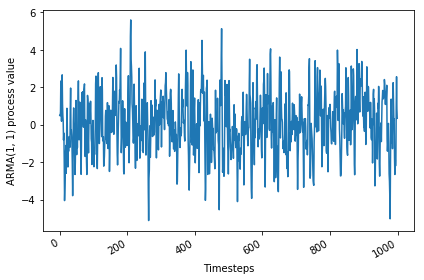

In [3]:
fig, ax = plt.subplots()
ax.plot(ARMA_1_1)
ax.set_xlabel('Timesteps')
ax.set_ylabel('ARMA(1, 1) process value')
fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ADF_result = adfuller(ARMA_1_1)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -6.42987868204269
p-value: 1.7078466680096923e-08


Our simulated ARMA(1,1) process is **stationary**

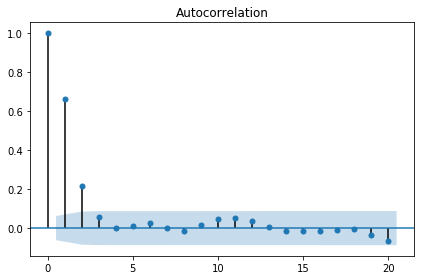

In [5]:
plot_acf(ARMA_1_1, lags=20);
plt.tight_layout()

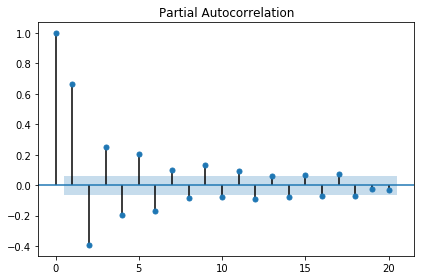

In [6]:
plot_pacf(ARMA_1_1, lags=20);
plt.tight_layout()

## Selecting a model using the AIC

In [7]:
from itertools import product

In [8]:
ps = range(0, 4)
qs = range(0, 4)
order_list = list(product(ps, qs))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [9]:
def optimize_ARMA(
    endog: Union[pd.Series, list],
    order_lst: list
) -> pd.DataFrame:
    
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    # sort
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [10]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.066092
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


### Understanding residual analysis

In [11]:
model = SARIMAX(ARMA_1_1, order=(1, 0, 1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

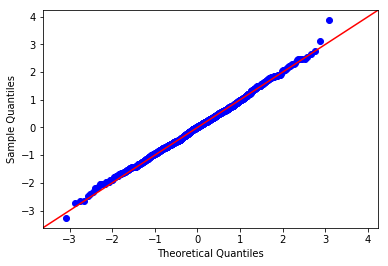

In [12]:
qqplot(residuals, line='45');

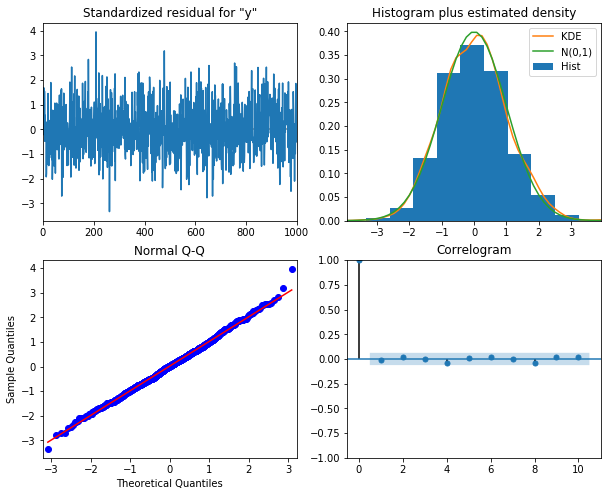

In [13]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [14]:
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11))
print(pvalue)

[0.86089685 0.76796558 0.90981746 0.72108901 0.81038546 0.82174996
 0.89406254 0.81750093 0.85241945 0.87409314]


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


## Applying the general modeling procedure to the bandwidth dataset

In [15]:
df = pd.read_csv('../data/bandwidth.csv')
df

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816
...,...
9995,740.546059
9996,738.906228
9997,736.057995
9998,733.559640


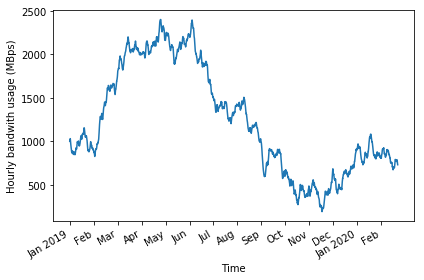

In [16]:
fig, ax = plt.subplots()
ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb']
)
fig.autofmt_xdate()
fig.tight_layout()

In [17]:
ADF_result = adfuller(df['hourly_bandwidth'])
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -0.8714653199452974
p-value: 0.7972240255014476


This time series is **not stationary**

In [18]:
bandwidth_diff = np.diff(df['hourly_bandwidth'], n=1)
ADF_result = adfuller(bandwidth_diff)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -20.69485386378892
p-value: 0.0


With a large, negative ADF statistic and a p-value that is much smaller than 0.05, we can say that our differenced series is **stationary**

In [19]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})
train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


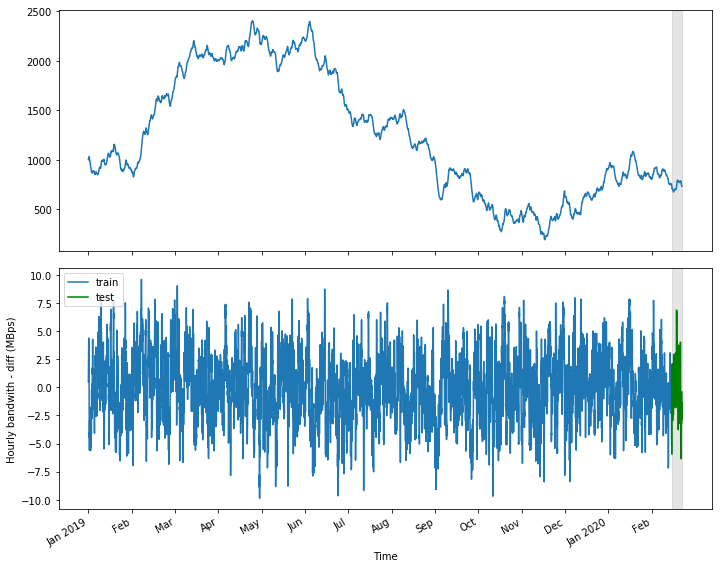

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(train['bandwidth_diff'], label='train')
ax2.plot(test['bandwidth_diff'], 'g', label='test')
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwith - diff (MBps)')
ax2.legend(loc=2)
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb']
)
fig.autofmt_xdate()
plt.tight_layout()

In [21]:
ps = range(0, 4)
qs = range(0, 4)
order_list = list(product(ps, qs))

In [22]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


The first three models all have an AIC of 27991, with only slight differences. Then, the ARMA(2,2) model is the model that should be selected. Its AIC value is very close to the ARMA(3,2) and ARMA(2,3) models, while being less complex, since it has four parameters to be estimated instead of five.

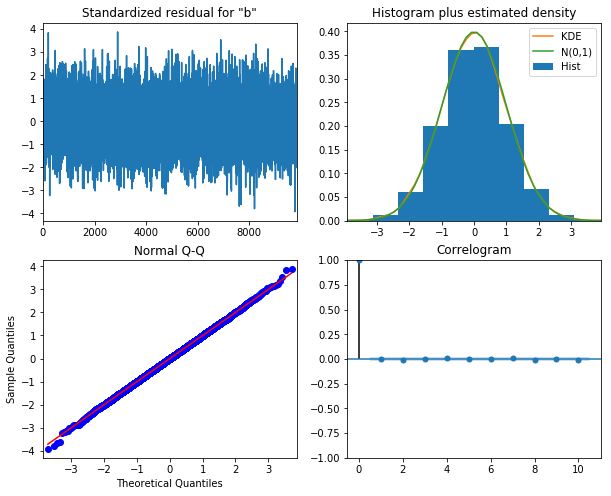

In [23]:
model = SARIMAX(train['bandwidth_diff'], order=(2, 0, 2), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8));

In [24]:
residuals = model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11))
print(pvalue)

[0.83725731 0.81124742 0.91441596 0.9315449  0.97367787 0.98101905
 0.95260714 0.91906661 0.95361504 0.96401518]


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


The returned p-values all exceed 0.05. Therefore, we can conclude that our residuals are indeed **uncorrelated**

## Forecasting bandwidth usage

In [25]:
def rolling_forecast(
    df: pd.DataFrame,
    train_len: int,
    horizon: int,
    window: int,
    method: str
) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2, 0, 2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [26]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

In [27]:
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last_value'] = pred_last_value
pred_df.loc[:, 'pred_ARMA'] = pred_ARMA

In [28]:
pred_df.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


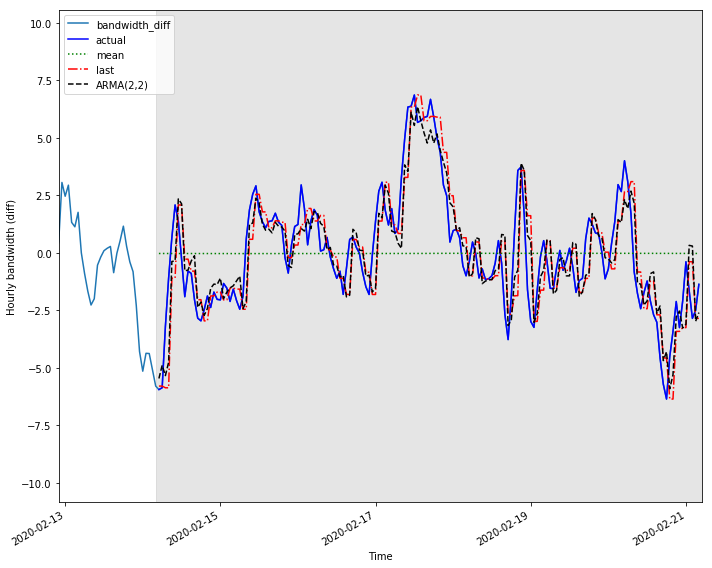

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df_diff['bandwidth_diff'])
ax.plot(pred_df['bandwidth_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth (diff)')
ax.axvspan(9830, 9999, color='#808080', alpha=0.2)
ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21']
)
fig.autofmt_xdate()
plt.tight_layout()

In [30]:
mse_mean = mean_squared_error(pred_df['bandwidth_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['bandwidth_diff'], pred_df['pred_last_value'])
mse_ARMA = mean_squared_error(pred_df['bandwidth_diff'], pred_df['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.3065269579893455 2.229758294773407 1.7690462113794294


In [31]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + pred_df['pred_ARMA'].cumsum()

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [32]:
df

,hourly_bandwidth,pred_bandwidth
0,1000.496714,NaN
1,1000.969408,NaN
2,1002.046019,NaN
3,1004.702118,NaN
4,1007.447816,NaN
...,...,...
9995,740.546059,721.377109
9996,738.906228,721.702460
9997,736.057995,721.996748
9998,733.559640,719.020898


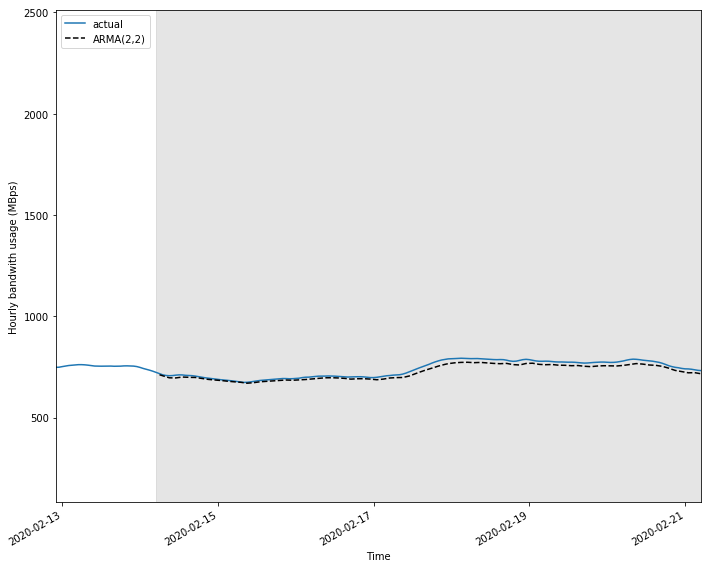

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['hourly_bandwidth'], label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
ax.axvspan(9831, 10000, color='#808080', alpha=0.2)
ax.set_xlim(9800, 9999)
plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21']
)
fig.autofmt_xdate()
plt.tight_layout()

In [34]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])
print(mae_ARMA_undiff)

14.000362770531265
